***
<font size="6"><center><b> HD-CapsNet: A Hierarchical Deep Capsule Network for Image Classification </b></center></font>
***

**Changing Model Architecture**
- **(Mod-3.1)** 32D>16D>8D (Coarse>Medium>FINE) use skip connections between Secondary Capsules $Concatenate([P_{caps}, S_{coarse}])$ > input for $S_{medium}$ and $Concatenate([P_{caps}, S_{medium}])$ > input for $S_{fine}$
- With $L_{Cons}$

# Files and Libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras import backend as K

import tensorflow_docs as tfdocs
import tensorflow_docs.plots

# Supporting Libraries:
    #Mathplot lib for ploting graphs
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
    # numpy and pandas
import numpy as np
import pandas as pd
    #system
import os
import sys
import csv
    #import other libraries
import math
import random
from datetime import datetime
from treelib import Tree
    # ML model, Dataset and evalution metrics
sys.path.append('../../') ### adding system parth for src folder
from src import datasets # load datasets
from src import MixUp # load datasets
from src import MixUp_add_loss # load datasets
from src import metrics # load hierarchcial metrics
from src import sysenv # load hierarchcial metrics
from src import models # load machine learning models

    ## Tensorflow_docs
import tensorflow_docs as tfdocs
import tensorflow_docs.plots

    # Auto reload local libraries if updated
%load_ext autoreload
%autoreload 2

# System information & GPU growth

In [2]:
systeminfo = sysenv.systeminfo()
print(systeminfo)


• Computer Name = SARUMAN
• Working Directory = D:\knoor\Deep Learning with Python\RunningOnServer\HD-CapsNet_MOD\Training_and_Analysis\5_CU_BIRD
• Python Version = 3.8.12 (default, Oct 12 2021, 03:01:40) [MSC v.1916 64 bit (AMD64)]
• TensorFlow Version = 2.8.0
• Keras Version = 2.8.0
• Current Environment = Anaconda Environment Name : D:\knoor\AnacondaEnvironment\py38tf28


In [3]:
gpus = "0,1,2,3,4,5,6,7" ## Selecting Available gpus (Multi-GPUS)
gpus = "7" ## Selecting Available gpus (Single GPU)
gpugrowth = sysenv.gpugrowth(gpus = gpus) ## Limiting GPUS from OS environment
gpugrowth.memory_growth() #GPU memory growth

Following GPUS are selected =  7
Done: GPU PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
1 Physical GPUs, 1 Logical GPUs


# Parameters

In [4]:
train_params = {"n_epochs" : 100,
                "batch_size": 16,
                "lr": 0.001, # Initial learning rate
                "lr_decay": 0.95, # Learning rate decay
                "decay_exe": 9, #learning rate decay execution epoch after
               }
model_params = {"optimizer": tf.keras.optimizers.Adam(train_params['lr']),
                "loss_function": models.MarginLoss(),
               }

# log directory

In [5]:
directory = sysenv.log_dir('5_CU_Bird/HD_CapsNet/Mod_3_2')

FOLDER CREATED =  ../../logs/5_CU_Bird/HD_CapsNet/Mod_3_2


# Import Dataset : CU BIRD

In [6]:
training_dataset,  test_dataset, val_dataset, tree, info = datasets.CU_Birds_200_2011(image_size=(64, 64), 
                                                                                  batch_size=train_params['batch_size'],
                                                                                  data_aug = 'mixup', # 'mixup'
                                                                                  data_normalizing = None) #'normalize'

In [7]:
for x,y in training_dataset.take(1):
    image_shape = x.shape[1:]
    coarse_label_shape = y[0].shape[1:]
    medium_label_shape = y[1].shape[1:]
    fine_label_shape = y[2].shape[1:]

## Learning Rate Decay Scheduler

In [8]:
def scheduler(epoch):
    learning_rate_init = train_params["lr"]
    
    if epoch > train_params["decay_exe"]:
        learning_rate_init = train_params["lr"] * (train_params["lr_decay"] ** (epoch-9))
        
    tf.summary.scalar('learning rate', data=learning_rate_init, step=epoch)
        
    return learning_rate_init

# Model Architecture

## Loss Function

In [9]:
## For Dynamic LossWeights
initial_lw = models.initial_lw({"coarse": info['Num_Coarse'],
                                "medium": info['Num_Medium'],
                                "fine": info['Num_Fine']})

lossweight = {'coarse_lw' : K.variable(value = initial_lw['coarse'], dtype="float32", name="coarse_lw"),
             'medium_lw' : K.variable(value = initial_lw['medium'], dtype="float32", name="medium_lw"),
             'fine_lw' : K.variable(value = initial_lw['fine'], dtype="float32", name="fine_lw"),
              'decoder_lw' : 0.0
             }

In [10]:
Matrix_coarse_to_medium_OneHot = tf.constant(info['Matrix_coarse_to_medium'], dtype=tf.float32)
Matrix_medium_to_fine_OneHot = tf.constant(info['Matrix_medium_to_fine'], dtype=tf.float32)

In [11]:
def margin_loss(y_true, y_proba):
    
    present_error_raw = tf.square(tf.maximum(0., 0.9 - y_proba), name="present_error_raw")
    absent_error_raw = tf.square(tf.maximum(0., y_proba - 0.1), name="absent_error_raw")
    L = tf.add(y_true * present_error_raw, 0.5 * (1.0 - y_true) * absent_error_raw,name="L")
    total_marginloss = tf.reduce_sum(L, axis=1, name="margin_loss")

    return total_marginloss


def CustomLoss(y_true_c, y_true_m, y_true_f, y_pred_c, y_pred_m, y_pred_f, LW_C, LW_M, LW_F):
    
    ML_c = margin_loss(y_true_c, y_pred_c)*LW_C
    ML_m = margin_loss(y_true_m, y_pred_m)*LW_M
    ML_f = margin_loss(y_true_f, y_pred_f)*LW_F
    
    batch_loss = ML_c + ML_m+ ML_f

    return tf.reduce_mean(batch_loss)

## Architecture

In [12]:
def get_compiled_model():
    
    ## Calling the HD-CapsNet Model
    model = models.HD_CapsNet_Mod_3_3(input_shape     = image_shape, 
                                      input_shape_yc  = coarse_label_shape,
                                      input_shape_ym  = medium_label_shape,
                                      input_shape_yf  = fine_label_shape, 
                                      no_coarse_class = info['Num_Coarse'], 
                                      no_medium_class = info['Num_Medium'], 
                                      no_fine_class   = info['Num_Fine'],
                                      PCap_n_dims     = 8, 
                                      SCap_f_dims     = 8, 
                                      SCap_m_dims     = 16, 
                                      SCap_c_dims     = 32)
    
    ## Saving Model Architecture
    keras.utils.plot_model(model, to_file = directory+"/Architecture.png", show_shapes=True)
    
    ## Add Loss for Model
    model.add_loss(CustomLoss(y_true_c            = model.inputs[1], 
                              y_true_m            = model.inputs[2], 
                              y_true_f            = model.inputs[3], 
                              y_pred_c            = model.output[0], 
                              y_pred_m            = model.output[1], 
                              y_pred_f            = model.output[2], 
                              LW_C                = lossweight['coarse_lw'], 
                              LW_M                = lossweight['medium_lw'], 
                              LW_F                = lossweight['fine_lw']
                             )
                  )
    
    ## Compile Model
    model.compile(optimizer='adam',                  
                  metrics={'prediction_fine': 'accuracy',
                           'prediction_medium': 'accuracy',
                           'prediction_coarse': 'accuracy'}
                 )
    return model

## Compile Model

In [13]:
model = get_compiled_model()

In [14]:
model.summary()

Model: "HD-CapsNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input_Image (InputLayer)       [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 block1_conv1 (Conv2D)          (None, 64, 64, 64)   1792        ['Input_Image[0][0]']            
                                                                                                  
 batch_normalization (BatchNorm  (None, 64, 64, 64)  256         ['block1_conv1[0][0]']           
 alization)                                                                                       
                                                                                                  
 block1_conv2 (Conv2D)          (None, 64, 64, 64)   36928       ['batch_normalization[0]

                                                                                                  
 prediction_medium (LengthLayer  (None, 123)         0           ['s_caps_medium[0][0]']          
 )                                                                                                
                                                                                                  
 prediction_fine (LengthLayer)  (None, 200)          0           ['s_caps_fine[0][0]']            
                                                                                                  
 tf.math.subtract (TFOpLambda)  (None, 39)           0           ['prediction_coarse[0][0]']      
                                                                                                  
 tf.math.subtract_1 (TFOpLambda  (None, 39)          0           ['prediction_coarse[0][0]']      
 )                                                                                                
          

 tf.math.multiply_8 (TFOpLambda  (None, 200)         0           ['input_yf[0][0]',               
 )                                                                'tf.math.square_4[0][0]']       
                                                                                                  
 tf.math.multiply_10 (TFOpLambd  (None, 200)         0           ['tf.math.multiply_9[0][0]',     
 a)                                                               'tf.math.square_5[0][0]']       
                                                                                                  
 tf.math.reduce_sum (TFOpLambda  (None,)             0           ['tf.math.add[0][0]']            
 )                                                                                                
                                                                                                  
 tf.math.reduce_sum_1 (TFOpLamb  (None,)             0           ['tf.math.add_1[0][0]']          
 da)      

## Data Augmentation

## Training Pipeline Alignment

In [15]:
#### Matching the pipeling with model inputs
def pipeline_multi_input_output(image, label):
    label_0 = label[0]
    label_1 = label[1]
    label_2 = label[2]
    return (image, label_0, label_1, label_2), (label_0, label_1, label_2)

training_dataset_match = training_dataset.map(pipeline_multi_input_output) ## Mixup dataset
val_dataset_match = val_dataset.map(pipeline_multi_input_output) ## Val Dataset

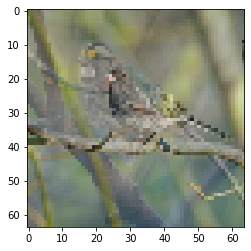

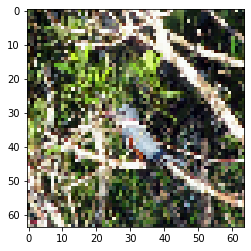

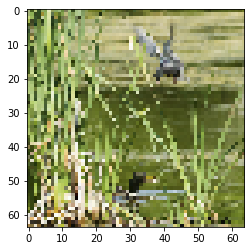

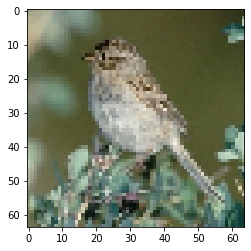

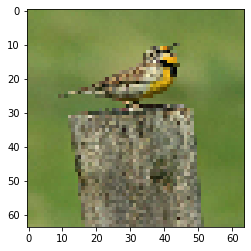

In [16]:
for x,y in training_dataset_match.take(5):
    plt.imshow(x[0][0])
    plt.show()
    

## Callback

In [17]:
tb = keras.callbacks.TensorBoard(directory+'./tb_logs'+ datetime.now().strftime("%Y%m%d-%H%M%S"))
log = keras.callbacks.CSVLogger(directory+'/log.csv', append=True)

checkpoint = keras.callbacks.ModelCheckpoint(directory+'/epoch-best.h5',
                                             monitor='val_prediction_fine_accuracy',
                                             save_best_only=True, 
                                             save_weights_only=True, 
                                             verbose=1)

change_lw = models.LossWeightsModifier(lossweight = lossweight,
                                       initial_lw = initial_lw,
                                       directory = directory)

lr_decay = keras.callbacks.LearningRateScheduler(scheduler)

## Model Training

In [18]:
model_save_dir = str(directory+'/trained_model.h5')
try:
    model.load_weights(model_save_dir)
except:
    history = model.fit(training_dataset_match,
                        epochs = train_params["n_epochs"],
                        validation_data = val_dataset_match,
                        callbacks = [tb,log,change_lw,lr_decay,checkpoint],
                        verbose=1)
    
    model.save_weights(model_save_dir)

Epoch 1/100
375/375 [==============================] - ETA: 0s - loss: 0.6469 - prediction_coarse_accuracy: 0.1917 - prediction_medium_accuracy: 0.0784 - prediction_fine_accuracy: 0.0199
  • Coarse Accuracy = 19.17% | Val_Accuracy = 18.54% | LossWeight = 0.41 
  • Medium Accuracy = 7.84% | Val_Accuracy = 4.52% | LossWeight = 0.34 
  • Fine   Accuracy = 1.99% | Val_Accuracy = 0.97% | LossWeight = 0.25 

Epoch 1: val_prediction_fine_accuracy improved from -inf to 0.00967, saving model to ../../logs/5_CU_Bird/HD_CapsNet/Mod_3_2\epoch-best.h5
375/375 [==============================] - 217s 481ms/step - loss: 0.6469 - prediction_coarse_accuracy: 0.1917 - prediction_medium_accuracy: 0.0784 - prediction_fine_accuracy: 0.0199 - val_loss: 0.6393 - val_prediction_coarse_accuracy: 0.1854 - val_prediction_medium_accuracy: 0.0452 - val_prediction_fine_accuracy: 0.0097 - lr: 0.0010
Epoch 2/100
375/375 [==============================] - ETA: 0s - loss: 0.5918 - prediction_coarse_accuracy: 0.2636 - pr

375/375 [==============================] - 212s 531ms/step - loss: 0.2912 - prediction_coarse_accuracy: 0.8784 - prediction_medium_accuracy: 0.8378 - prediction_fine_accuracy: 0.7481 - val_loss: 0.5417 - val_prediction_coarse_accuracy: 0.4032 - val_prediction_medium_accuracy: 0.2320 - val_prediction_fine_accuracy: 0.1512 - lr: 0.0010
Epoch 10/100
375/375 [==============================] - ETA: 0s - loss: 0.2544 - prediction_coarse_accuracy: 0.9076 - prediction_medium_accuracy: 0.8869 - prediction_fine_accuracy: 0.8248
  • Coarse Accuracy = 90.76% | Val_Accuracy = 39.97% | LossWeight = 0.35 
  • Medium Accuracy = 88.69% | Val_Accuracy = 23.27% | LossWeight = 0.32 
  • Fine   Accuracy = 82.48% | Val_Accuracy = 15.64% | LossWeight = 0.33 

Epoch 10: val_prediction_fine_accuracy improved from 0.15119 to 0.15637, saving model to ../../logs/5_CU_Bird/HD_CapsNet/Mod_3_2\epoch-best.h5
375/375 [==============================] - 203s 500ms/step - loss: 0.2544 - prediction_coarse_accuracy: 0.9076

Epoch 19/100
375/375 [==============================] - ETA: 0s - loss: 0.1178 - prediction_coarse_accuracy: 0.9645 - prediction_medium_accuracy: 0.9695 - prediction_fine_accuracy: 0.9651
  • Coarse Accuracy = 96.45% | Val_Accuracy = 39.21% | LossWeight = 0.47 
  • Medium Accuracy = 96.95% | Val_Accuracy = 23.13% | LossWeight = 0.30 
  • Fine   Accuracy = 96.51% | Val_Accuracy = 15.40% | LossWeight = 0.23 

Epoch 19: val_prediction_fine_accuracy did not improve from 0.16500
375/375 [==============================] - 213s 528ms/step - loss: 0.1178 - prediction_coarse_accuracy: 0.9645 - prediction_medium_accuracy: 0.9695 - prediction_fine_accuracy: 0.9651 - val_loss: 0.5361 - val_prediction_coarse_accuracy: 0.3921 - val_prediction_medium_accuracy: 0.2313 - val_prediction_fine_accuracy: 0.1540 - lr: 6.3025e-04
Epoch 20/100
375/375 [==============================] - ETA: 0s - loss: 0.1120 - prediction_coarse_accuracy: 0.9623 - prediction_medium_accuracy: 0.9643 - prediction_fine_accuracy: 

375/375 [==============================] - 213s 533ms/step - loss: 0.1028 - prediction_coarse_accuracy: 0.9681 - prediction_medium_accuracy: 0.9723 - prediction_fine_accuracy: 0.9703 - val_loss: 0.5438 - val_prediction_coarse_accuracy: 0.3980 - val_prediction_medium_accuracy: 0.2254 - val_prediction_fine_accuracy: 0.1491 - lr: 3.9721e-04
Epoch 29/100
375/375 [==============================] - ETA: 0s - loss: 0.0995 - prediction_coarse_accuracy: 0.9700 - prediction_medium_accuracy: 0.9708 - prediction_fine_accuracy: 0.9693
  • Coarse Accuracy = 97.00% | Val_Accuracy = 40.97% | LossWeight = 0.45 
  • Medium Accuracy = 97.08% | Val_Accuracy = 22.47% | LossWeight = 0.32 
  • Fine   Accuracy = 96.93% | Val_Accuracy = 15.40% | LossWeight = 0.23 

Epoch 29: val_prediction_fine_accuracy did not improve from 0.16500
375/375 [==============================] - 202s 499ms/step - loss: 0.0995 - prediction_coarse_accuracy: 0.9700 - prediction_medium_accuracy: 0.9708 - prediction_fine_accuracy: 0.969

375/375 [==============================] - ETA: 0s - loss: 0.0986 - prediction_coarse_accuracy: 0.9683 - prediction_medium_accuracy: 0.9696 - prediction_fine_accuracy: 0.9690
  • Coarse Accuracy = 96.83% | Val_Accuracy = 40.97% | LossWeight = 0.45 
  • Medium Accuracy = 96.96% | Val_Accuracy = 22.44% | LossWeight = 0.32 
  • Fine   Accuracy = 96.90% | Val_Accuracy = 14.53% | LossWeight = 0.22 

Epoch 38: val_prediction_fine_accuracy did not improve from 0.16500
375/375 [==============================] - 215s 531ms/step - loss: 0.0986 - prediction_coarse_accuracy: 0.9683 - prediction_medium_accuracy: 0.9696 - prediction_fine_accuracy: 0.9690 - val_loss: 0.5399 - val_prediction_coarse_accuracy: 0.4097 - val_prediction_medium_accuracy: 0.2244 - val_prediction_fine_accuracy: 0.1453 - lr: 2.3783e-04
Epoch 39/100
375/375 [==============================] - ETA: 0s - loss: 0.0968 - prediction_coarse_accuracy: 0.9721 - prediction_medium_accuracy: 0.9736 - prediction_fine_accuracy: 0.9696
  • Co

375/375 [==============================] - 210s 523ms/step - loss: 0.0951 - prediction_coarse_accuracy: 0.9738 - prediction_medium_accuracy: 0.9748 - prediction_fine_accuracy: 0.9733 - val_loss: 0.5377 - val_prediction_coarse_accuracy: 0.4052 - val_prediction_medium_accuracy: 0.2302 - val_prediction_fine_accuracy: 0.1502 - lr: 1.4989e-04
Epoch 48/100
375/375 [==============================] - ETA: 0s - loss: 0.0967 - prediction_coarse_accuracy: 0.9731 - prediction_medium_accuracy: 0.9731 - prediction_fine_accuracy: 0.9721
  • Coarse Accuracy = 97.31% | Val_Accuracy = 40.73% | LossWeight = 0.44 
  • Medium Accuracy = 97.31% | Val_Accuracy = 22.85% | LossWeight = 0.33 
  • Fine   Accuracy = 97.21% | Val_Accuracy = 14.98% | LossWeight = 0.23 

Epoch 48: val_prediction_fine_accuracy did not improve from 0.16500
375/375 [==============================] - 204s 506ms/step - loss: 0.0967 - prediction_coarse_accuracy: 0.9731 - prediction_medium_accuracy: 0.9731 - prediction_fine_accuracy: 0.972

375/375 [==============================] - ETA: 0s - loss: 0.0914 - prediction_coarse_accuracy: 0.9733 - prediction_medium_accuracy: 0.9755 - prediction_fine_accuracy: 0.9730
  • Coarse Accuracy = 97.33% | Val_Accuracy = 40.52% | LossWeight = 0.46 
  • Medium Accuracy = 97.55% | Val_Accuracy = 22.58% | LossWeight = 0.31 
  • Fine   Accuracy = 97.30% | Val_Accuracy = 15.19% | LossWeight = 0.23 

Epoch 57: val_prediction_fine_accuracy did not improve from 0.16500
375/375 [==============================] - 223s 558ms/step - loss: 0.0914 - prediction_coarse_accuracy: 0.9733 - prediction_medium_accuracy: 0.9755 - prediction_fine_accuracy: 0.9730 - val_loss: 0.5390 - val_prediction_coarse_accuracy: 0.4052 - val_prediction_medium_accuracy: 0.2258 - val_prediction_fine_accuracy: 0.1519 - lr: 8.9745e-05
Epoch 58/100
375/375 [==============================] - ETA: 0s - loss: 0.0954 - prediction_coarse_accuracy: 0.9713 - prediction_medium_accuracy: 0.9725 - prediction_fine_accuracy: 0.9731
  • Co

375/375 [==============================] - 211s 521ms/step - loss: 0.0926 - prediction_coarse_accuracy: 0.9756 - prediction_medium_accuracy: 0.9728 - prediction_fine_accuracy: 0.9731 - val_loss: 0.5359 - val_prediction_coarse_accuracy: 0.4142 - val_prediction_medium_accuracy: 0.2313 - val_prediction_fine_accuracy: 0.1484 - lr: 5.6562e-05
Epoch 67/100
375/375 [==============================] - ETA: 0s - loss: 0.0944 - prediction_coarse_accuracy: 0.9730 - prediction_medium_accuracy: 0.9730 - prediction_fine_accuracy: 0.9703
  • Coarse Accuracy = 97.30% | Val_Accuracy = 41.49% | LossWeight = 0.44 
  • Medium Accuracy = 97.30% | Val_Accuracy = 23.20% | LossWeight = 0.32 
  • Fine   Accuracy = 97.03% | Val_Accuracy = 14.91% | LossWeight = 0.24 

Epoch 67: val_prediction_fine_accuracy did not improve from 0.16500
375/375 [==============================] - 220s 528ms/step - loss: 0.0944 - prediction_coarse_accuracy: 0.9730 - prediction_medium_accuracy: 0.9730 - prediction_fine_accuracy: 0.970

375/375 [==============================] - ETA: 0s - loss: 0.0931 - prediction_coarse_accuracy: 0.9735 - prediction_medium_accuracy: 0.9741 - prediction_fine_accuracy: 0.9726
  • Coarse Accuracy = 97.35% | Val_Accuracy = 41.63% | LossWeight = 0.45 
  • Medium Accuracy = 97.41% | Val_Accuracy = 22.78% | LossWeight = 0.32 
  • Fine   Accuracy = 97.26% | Val_Accuracy = 15.22% | LossWeight = 0.23 

Epoch 76: val_prediction_fine_accuracy did not improve from 0.16500
375/375 [==============================] - 219s 547ms/step - loss: 0.0931 - prediction_coarse_accuracy: 0.9735 - prediction_medium_accuracy: 0.9741 - prediction_fine_accuracy: 0.9726 - val_loss: 0.5389 - val_prediction_coarse_accuracy: 0.4163 - val_prediction_medium_accuracy: 0.2278 - val_prediction_fine_accuracy: 0.1522 - lr: 3.3866e-05
Epoch 77/100
375/375 [==============================] - ETA: 0s - loss: 0.0924 - prediction_coarse_accuracy: 0.9771 - prediction_medium_accuracy: 0.9778 - prediction_fine_accuracy: 0.9753
  • Co

375/375 [==============================] - 275s 669ms/step - loss: 0.0931 - prediction_coarse_accuracy: 0.9756 - prediction_medium_accuracy: 0.9743 - prediction_fine_accuracy: 0.9736 - val_loss: 0.5344 - val_prediction_coarse_accuracy: 0.4170 - val_prediction_medium_accuracy: 0.2295 - val_prediction_fine_accuracy: 0.1515 - lr: 2.1344e-05
Epoch 86/100
375/375 [==============================] - ETA: 0s - loss: 0.0946 - prediction_coarse_accuracy: 0.9760 - prediction_medium_accuracy: 0.9768 - prediction_fine_accuracy: 0.9741
  • Coarse Accuracy = 97.60% | Val_Accuracy = 41.53% | LossWeight = 0.44 
  • Medium Accuracy = 97.68% | Val_Accuracy = 22.95% | LossWeight = 0.32 
  • Fine   Accuracy = 97.41% | Val_Accuracy = 15.22% | LossWeight = 0.24 

Epoch 86: val_prediction_fine_accuracy did not improve from 0.16500
375/375 [==============================] - 258s 632ms/step - loss: 0.0946 - prediction_coarse_accuracy: 0.9760 - prediction_medium_accuracy: 0.9768 - prediction_fine_accuracy: 0.974

375/375 [==============================] - ETA: 0s - loss: 0.0925 - prediction_coarse_accuracy: 0.9695 - prediction_medium_accuracy: 0.9718 - prediction_fine_accuracy: 0.9696
  • Coarse Accuracy = 96.95% | Val_Accuracy = 41.70% | LossWeight = 0.46 
  • Medium Accuracy = 97.18% | Val_Accuracy = 22.75% | LossWeight = 0.31 
  • Fine   Accuracy = 96.96% | Val_Accuracy = 15.22% | LossWeight = 0.23 

Epoch 95: val_prediction_fine_accuracy did not improve from 0.16500
375/375 [==============================] - 259s 628ms/step - loss: 0.0925 - prediction_coarse_accuracy: 0.9695 - prediction_medium_accuracy: 0.9718 - prediction_fine_accuracy: 0.9696 - val_loss: 0.5318 - val_prediction_coarse_accuracy: 0.4170 - val_prediction_medium_accuracy: 0.2275 - val_prediction_fine_accuracy: 0.1522 - lr: 1.2779e-05
Epoch 96/100
375/375 [==============================] - ETA: 0s - loss: 0.0908 - prediction_coarse_accuracy: 0.9763 - prediction_medium_accuracy: 0.9760 - prediction_fine_accuracy: 0.9728
  • Co

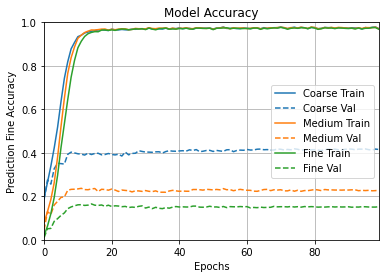

In [19]:
try:
    history_dict = history.history

    plotter = tfdocs.plots.HistoryPlotter()
    plotter.plot({"Coarse": history}, metric = "prediction_coarse_accuracy")
    plotter.plot({"Medium": history}, metric = "prediction_medium_accuracy")
    plotter.plot({"Fine": history}, metric = "prediction_fine_accuracy")
    plt.title("Model Accuracy")
    plt.ylim([0,1])
except:
    print('Trained model weights loaded')

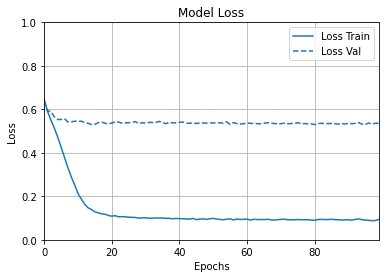

In [20]:
try:
    plotter = tfdocs.plots.HistoryPlotter()
    plotter.plot({"loss": history}, metric = "loss")
    plt.title("Model Loss")
    plt.ylim([0,1])
except:
    print('Trained model weights loaded')

## Model Analysis

In [21]:
final_model = keras.Model(model.inputs[:1], model.output)

lossfn = models.MarginLoss()
final_model.compile(optimizer='adam', 
                    loss={'prediction_fine' : lossfn,
                          'prediction_medium' : lossfn,
                          'prediction_coarse' : lossfn},

                    loss_weights={'prediction_fine' : lossweight['fine_lw'],
                                  'prediction_medium' : lossweight['medium_lw'],
                                  'prediction_coarse' : lossweight['coarse_lw']},

                    metrics={'prediction_fine': 'accuracy',
                             'prediction_medium': 'accuracy',
                             'prediction_coarse': 'accuracy'
                            }
                   )

In [22]:
results = final_model.evaluate(test_dataset)
for n in range(len(results)):
    print(str(n+1)+'.',final_model.metrics_names[n], '==>', results[n])
model_predictions = final_model.predict(test_dataset)

182/182 [==============================] - 39s 193ms/step - loss: 0.5345 - prediction_coarse_loss: 0.4358 - prediction_medium_loss: 0.5835 - prediction_fine_loss: 0.6457 - prediction_coarse_accuracy: 0.4153 - prediction_medium_accuracy: 0.2292 - prediction_fine_accuracy: 0.1522
1. loss ==> 0.5345010757446289
2. prediction_coarse_loss ==> 0.4358205497264862
3. prediction_medium_loss ==> 0.5835272073745728
4. prediction_fine_loss ==> 0.6457123756408691
5. prediction_coarse_accuracy ==> 0.41525715589523315
6. prediction_medium_accuracy ==> 0.22920262813568115
7. prediction_fine_accuracy ==> 0.15222644805908203


In [25]:
def predict_from_pipeline(model, dataset):
    y_pred = []
    y_true = []
    for x, y in dataset:
        batch_pred = model.predict(x)
        for i in range(len(batch_pred)):
            if i >= len(y_pred):
                y_pred.append(None)
                y_true.append(None)
            if y_pred[i] is None:
                y_pred[i] = batch_pred[i]
                y_true[i] = list(y[i].numpy())
            else:
                y_pred[i] = np.concatenate([y_pred[i], batch_pred[i]])
                y_true[i] = y_true[i] + list(y[i].numpy())
    return y_true, y_pred

In [26]:
predictions = []
predictions.append(predict_from_pipeline(final_model, test_dataset))

In [27]:
dataset= {'y_test_coarse':predictions[0][0][0], 
          'y_test_medium':predictions[0][0][1], 
          'y_test_fine':predictions[0][0][2]}

In [28]:
true_label = [dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']]
pred_label = [predictions[0][1][0],predictions[0][1][1],predictions[0][1][2]]

  • Confusion_Matrix 

  • COARSE LEVEL 
[[ 2  1  0 ...  0  0  0]
 [ 0 18  6 ...  0  0  0]
 [ 0  5 25 ...  1  0  0]
 ...
 [ 0  1  0 ... 14  6  6]
 [ 0  1  0 ...  0 59  3]
 [ 0  0  0 ...  2  4 15]]

  • MEDIUM LEVEL 
[[ 4  1  0 ...  0  0  0]
 [ 0 12  0 ...  0  0  0]
 [ 0  0  5 ...  1  0  0]
 ...
 [ 0  0  0 ... 23  0  0]
 [ 0  0  0 ...  0 10  0]
 [ 0  0  0 ...  0  0  3]]

  • FINE LEVEL 
[[0 0 2 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [0 2 1 ... 0 0 0]
 ...
 [1 0 0 ... 5 0 0]
 [0 0 0 ... 1 0 1]
 [0 0 0 ... 0 0 7]]

  • Classification Report 


  • COARSE LEVEL 


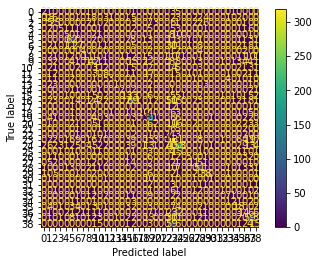

D:\knoor\AnacondaEnvironment\py38tf28\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\knoor\AnacondaEnvironment\py38tf28\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\knoor\AnacondaEnvironment\py38tf28\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0    0.33333   0.14286   0.20000        14
           1    0.26087   0.26866   0.26471        67
           2    0.42373   0.37879   0.40000        66
           3    0.45455   0.14286   0.21739        35
           4    0.35714   0.17241   0.23256        29
           5    0.53448   0.62000   0.57407       100
           6    0.40909   0.23894   0.30168       113
           7    0.80000   0.26667   0.40000        15
           8    0.35484   0.17742   0.23656        62
           9    0.31818   0.35593   0.33600       118
          10    0.27500   0.18966   0.22449        58
          11    0.20513   0.17021   0.18605        47
          12    0.60000   0.13043   0.21429        23
          13    0.50000   0.08333   0.14286        12
          14    0.66667   0.16667   0.26667        12
          15    0.35135   0.19697   0.25243        66
          16    0.39655   0.35025   0.37197       197
          17    0.00000   0

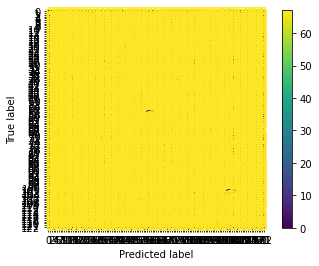

              precision    recall  f1-score   support

           0    0.28571   0.20000   0.23529        20
           1    0.35294   0.44444   0.39344        27
           2    0.41667   0.45455   0.43478        11
           3    0.25000   0.11111   0.15385         9
           4    0.04762   0.07143   0.05714        14
           5    0.18367   0.21429   0.19780        42
           6    0.00000   0.00000   0.00000        13
           7    0.46667   0.46667   0.46667        15
           8    0.00000   0.00000   0.00000        16
           9    0.26667   0.25000   0.25806        16
          10    0.16667   0.12500   0.14286        16
          11    0.11765   0.12500   0.12121        16
          12    0.34615   0.25714   0.29508        35
          13    0.15385   0.11765   0.13333        17
          14    0.06250   0.11111   0.08000         9
          15    0.14815   0.09756   0.11765        41
          16    0.28571   0.40000   0.33333        10
          17    0.46154   0

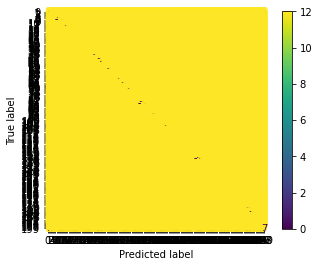

              precision    recall  f1-score   support

           0    0.00000   0.00000   0.00000        15
           1    0.00000   0.00000   0.00000        16
           2    0.10000   0.06250   0.07692        16
           3    0.04348   0.07692   0.05556        13
           4    0.25000   0.28571   0.26667         7
           5    0.00000   0.00000   0.00000         4
           6    0.26667   0.25000   0.25806        16
           7    0.10000   0.20000   0.13333        10
           8    0.04545   0.08333   0.05882        12
           9    0.42857   0.54545   0.48000        11
          10    0.07692   0.05882   0.06667        17
          11    0.71429   0.76923   0.74074        13
          12    0.10000   0.25000   0.14286        12
          13    0.22222   0.30769   0.25806        13
          14    0.05263   0.06250   0.05714        16
          15    0.21053   0.26667   0.23529        15
          16    0.30000   0.60000   0.40000        10
          17    0.07143   0

In [29]:
metrics.lvl_wise_metric(true_label,pred_label)

In [30]:
h_measurements,consistency,exact_match = metrics.hmeasurements(true_label,pred_label,tree)
print('\nHierarchical Precision =',h_measurements[0],
      '\nHierarchical Recall =', h_measurements[1],
      '\nHierarchical F1-Score =',h_measurements[2],
      '\nConsistency = ', consistency,
      '\nExact Match = ', exact_match,
     )


Hierarchical Precision = 0.24887239673225175 
Hierarchical Recall = 0.3153837302957082 
Hierarchical F1-Score = 0.2738478776621683 
Consistency =  0.28339661719019676 
Exact Match =  0.09285467725233
